# Capstone Project - Predicting Smartphone Purchase of Multi Category Store
## Part 4 - Product Weekly Sales Prediction

### Table of Contents

* [Section 1.  Import dataset](#section_1)
* [Section 2.  Feature engineering](#section_2)
    * [2.1 Features with historical sales](#section_2_a)
    * [2.2 Features with historical views](#section_2_b)
    * [2.3 Features with historical carts](#section_2_c)
* [Section 3. Weekly sales prediction](#section_3)
    * [3.1 Preparation and pipeline](#section_3_a)
    * [3.2 Modelling](#section_3_b)
        * [3.2.1 Linear regression and feature/target transforming](#section_3_2_1)
        * [3.2.2 Model comparison](#section_3_2_2)
        * [3.2.3 Feature importance](#section_3_2_3)
    * [3.3 Summary](#section_3_c)



## Section 1.  Import dataset <a class="anchor" id="section_1"></a> 
Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

In [2]:
column_name_and_dtype = {'event_type': 'category',
                         'product_id': 'category',
                         'category_id': 'category',
                         'category_code': 'category',
                         'brand': 'category',
                         'user_id': 'category',
                         'user_session': 'category'}

use_columns = ['event_time',
               'event_type',
               'product_id',
               'price',
               'category_code',
               'brand',
               'user_session',
              ]

In [3]:
product_summary = pd.read_csv('csv_files/product_summary.csv',
                              dtype = column_name_and_dtype)

In [140]:
%%time
df = pd.read_csv('csv_files/dataset.gz', 
                 compression = 'gzip', 
                 low_memory = True, 
                 dtype = column_name_and_dtype,
                 parse_dates = ['event_time'])


Wall time: 10min 38s


In [30]:
product_summary.head()

,product_id,price_count,brand,category,product
0,1005169,183,samsung,electronics,smartphone
1,1005168,178,samsung,electronics,smartphone
2,1005171,173,samsung,electronics,smartphone
3,1005100,168,samsung,electronics,smartphone
4,1004874,163,samsung,electronics,smartphone


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68650184 entries, 0 to 68650183
Data columns (total 12 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     category           
 2   product_id     category           
 3   category_code  category           
 4   brand          category           
 5   price          float64            
 6   user_id        category           
 7   user_session   category           
 8   views          int64              
 9   carts          int64              
 10  sales          int64              
 11  week_id        int64              
dtypes: category(6), datetime64[ns, UTC](1), float64(1), int64(4)
memory usage: 5.1 GB


## Section 2.  Feature engineering <a class="anchor" id="section_2"></a> 


In [32]:
purchase = df[df['event_type']=='purchase'].reset_index(drop = True)
purchase.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,views,carts,sales,week_id
0,2019-10-01 00:02:14+00:00,purchase,1004856,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,0,0,1,40
1,2019-10-01 00:04:37+00:00,purchase,1002532,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,1,40
2,2019-10-01 00:07:07+00:00,purchase,13800054,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,0,0,1,40
3,2019-10-01 00:09:26+00:00,purchase,4804055,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,1,40
4,2019-10-01 00:09:54+00:00,purchase,4804056,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,1,40


In [33]:
df_sales = purchase.groupby(['product_id','week_id']) \
                   .agg(average_price = ('price' , 'mean'),
                        sales = ('sales' , 'sum')) \
                   .reset_index()

df_sales.dropna(inplace = True)

df_sales.head()

,product_id,week_id,average_price,sales
0,1001588,40,128.260,4.0
1,1001588,41,128.174,5.0
2,1001588,42,128.115,2.0
3,1001588,43,128.040,1.0
4,1001588,44,127.860,1.0


Limit products to at least 100 purchases

In [34]:
df_sales = df_sales[df_sales['sales'] > 100]
df_sales.shape

(1641, 4)

Inspect one product

In [35]:
df_sales[df_sales['product_id']=='1002531']

,product_id,week_id,average_price,sales
180258,1002531,46,721.801837,196.0


### Section 2.1  Features with historical sales <a class="anchor" id="section_2_a"></a> 


In [36]:
dummy = df_sales.head(4).copy()
dummy['product_id'] = '0'
dummy['week_id'] = df_sales['week_id'].min() - np.arange(4) - 1

dm = pd.concat([df_sales, dummy]).reset_index(drop=True)
#pv = pd.pivot_table(dm, values='sales', index = 'product_id', columns='week_id', fill_value=0)
pv = pd.pivot_table(dm, values='sales', index = 'product_id', columns='week_id')
pv

week_id,36,37,38,39,40,41,42,43,44,45,46,47,48
product_id,,,,,,,,,,,,,
0,1503.0,1800.0,1338.0,1339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002524,NaN,NaN,NaN,NaN,1339.0,1338.0,1800.0,1503.0,1151.0,1172.0,2243.0,1259.0,1072.0
1002525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.0,117.0,151.0
1002528,NaN,NaN,NaN,NaN,115.0,157.0,122.0,167.0,NaN,NaN,244.0,270.0,221.0
1002531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000094,NaN,NaN,NaN,NaN,149.0,264.0,173.0,133.0,116.0,157.0,519.0,235.0,139.0
6000227,NaN,NaN,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN,241.0,NaN,NaN
6000229,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,110.0,NaN,NaN


In [39]:
dm = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='sales') \
       .sort_values(['product_id','week_id'])

dm['sales_last_1w'] = dm.rolling(2).sum()['sales'] - dm['sales']
dm['sales_last_2w'] = dm.rolling(3).sum()['sales'] - dm['sales']
dm['sales_last_4w'] = dm.rolling(5).sum()['sales'] - dm['sales']

dm = dm[dm['week_id'] >= df_sales['week_id'].min()]
dm.head(16)

,product_id,week_id,sales,sales_last_1w,sales_last_2w,sales_last_4w
1496,1002524,40,1339.0,NaN,NaN,NaN
1870,1002524,41,1338.0,1339.0,NaN,NaN
2244,1002524,42,1800.0,1338.0,2677.0,NaN
2618,1002524,43,1503.0,1800.0,3138.0,NaN
2992,1002524,44,1151.0,1503.0,3303.0,5980.0
3366,1002524,45,1172.0,1151.0,2654.0,5792.0
3740,1002524,46,2243.0,1172.0,2323.0,5626.0
4114,1002524,47,1259.0,2243.0,3415.0,6069.0
4488,1002524,48,1072.0,1259.0,3502.0,5825.0
1497,1002525,40,NaN,NaN,NaN,NaN


In [40]:
df_sales = df_sales.merge(dm[['product_id', 'week_id', 'sales_last_1w', 'sales_last_2w', 'sales_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w
0,1002524,40,512.748910,1339.0,NaN,NaN,NaN
1,1002524,41,538.474783,1338.0,1339.0,NaN,NaN
2,1002524,42,546.966950,1800.0,1338.0,2677.0,NaN
3,1002524,43,532.124079,1503.0,1800.0,3138.0,NaN
4,1002524,44,531.325986,1151.0,1503.0,3303.0,5980.0
5,1002524,45,558.603703,1172.0,1151.0,2654.0,5792.0
6,1002524,46,562.885698,2243.0,1172.0,2323.0,5626.0
7,1002524,47,535.484464,1259.0,2243.0,3415.0,6069.0
8,1002524,48,532.828853,1072.0,1259.0,3502.0,5825.0
9,1002525,46,720.250570,228.0,NaN,NaN,NaN


### Section 2.2  Features with historical views <a class="anchor" id="section_2_b"></a> 


In [41]:
filtered = df[df['views'] > 0].reset_index(drop = True)
grouped = filtered.groupby(['product_id','week_id']) \
                  .agg(views = ('event_type' , 'count')) \
                  .reset_index()

dm = pd.concat([grouped, dummy.rename(columns = {'sales': 'views'})]).reset_index(drop=True)
pv = pd.pivot_table(dm, values='views', index = 'product_id', columns='week_id')

dm = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='views') \
       .sort_values(['product_id','week_id'])

dm['views_last_1w'] = dm.rolling(2).sum()['views'] - dm['views']
dm['views_last_2w'] = dm.rolling(3).sum()['views'] - dm['views']
dm['views_last_4w'] = dm.rolling(5).sum()['views'] - dm['views']

dm = dm[dm['week_id'] >= df_sales['week_id'].min()]

df_sales = df_sales.merge(dm[['product_id', 'week_id', 'views_last_1w', 'views_last_2w', 'views_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w
0,1002524,40,512.748910,1339.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1002524,41,538.474783,1338.0,1339.0,NaN,NaN,25066.0,NaN,NaN
2,1002524,42,546.966950,1800.0,1338.0,2677.0,NaN,24628.0,49694.0,NaN
3,1002524,43,532.124079,1503.0,1800.0,3138.0,NaN,29636.0,54264.0,NaN
4,1002524,44,531.325986,1151.0,1503.0,3303.0,5980.0,26627.0,56263.0,105957.0
5,1002524,45,558.603703,1172.0,1151.0,2654.0,5792.0,21821.0,48448.0,102712.0
6,1002524,46,562.885698,2243.0,1172.0,2323.0,5626.0,26004.0,47825.0,104088.0
7,1002524,47,535.484464,1259.0,2243.0,3415.0,6069.0,52461.0,78465.0,126913.0
8,1002524,48,532.828853,1072.0,1259.0,3502.0,5825.0,22867.0,75328.0,123153.0
9,1002525,46,720.250570,228.0,NaN,NaN,NaN,646.0,1089.0,2737.0


### Section 2.3  Features with historical carts <a class="anchor" id="section_2_c"></a> 


In [43]:
filtered = df[df['carts'] > 0].reset_index(drop = True)
grouped = filtered.groupby(['product_id','week_id']) \
                  .agg(carts = ('event_type' , 'count')) \
                  .reset_index()

dm = pd.concat([grouped, dummy.rename(columns = {'sales': 'carts'})]).reset_index(drop=True)
pv = pd.pivot_table(dm, values='carts', index = 'product_id', columns='week_id')

dm = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='carts') \
       .sort_values(['product_id','week_id'])

dm['carts_last_1w'] = dm.rolling(2).sum()['carts'] - dm['carts']
dm['carts_last_2w'] = dm.rolling(3).sum()['carts'] - dm['carts']
dm['carts_last_4w'] = dm.rolling(5).sum()['carts'] - dm['carts']

dm = dm[dm['week_id'] >= df_sales['week_id'].min()]

df_sales = df_sales.merge(dm[['product_id', 'week_id', 'carts_last_1w', 'carts_last_2w', 'carts_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w,carts_last_1w,carts_last_2w,carts_last_4w
0,1002524,40,512.748910,1339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002524,41,538.474783,1338.0,1339.0,NaN,NaN,25066.0,NaN,NaN,1960.0,NaN,NaN
2,1002524,42,546.966950,1800.0,1338.0,2677.0,NaN,24628.0,49694.0,NaN,1511.0,3471.0,NaN
3,1002524,43,532.124079,1503.0,1800.0,3138.0,NaN,29636.0,54264.0,NaN,3384.0,4895.0,NaN
4,1002524,44,531.325986,1151.0,1503.0,3303.0,5980.0,26627.0,56263.0,105957.0,2739.0,6123.0,9594.0
5,1002524,45,558.603703,1172.0,1151.0,2654.0,5792.0,21821.0,48448.0,102712.0,1354.0,4093.0,8988.0
6,1002524,46,562.885698,2243.0,1172.0,2323.0,5626.0,26004.0,47825.0,104088.0,1984.0,3338.0,9461.0
7,1002524,47,535.484464,1259.0,2243.0,3415.0,6069.0,52461.0,78465.0,126913.0,9308.0,11292.0,15385.0
8,1002524,48,532.828853,1072.0,1259.0,3502.0,5825.0,22867.0,75328.0,123153.0,2817.0,12125.0,15463.0
9,1002525,46,720.250570,228.0,NaN,NaN,NaN,646.0,1089.0,2737.0,5.0,5.0,5.0


In [44]:
#df_sales = df_sales.merge(df_elasticity[['product_id', 'elasticity', 'product', 'brand']],
#                          how = 'left',
#                          on = 'product_id')
#df_sales.head(10)

In [45]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 0 to 1640
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     1641 non-null   object 
 1   week_id        1641 non-null   object 
 2   average_price  1641 non-null   float64
 3   sales          1641 non-null   float64
 4   sales_last_1w  1184 non-null   float64
 5   sales_last_2w  945 non-null    float64
 6   sales_last_4w  585 non-null    float64
 7   views_last_1w  1505 non-null   float64
 8   views_last_2w  1346 non-null   float64
 9   views_last_4w  979 non-null    float64
 10  carts_last_1w  1505 non-null   float64
 11  carts_last_2w  1346 non-null   float64
 12  carts_last_4w  979 non-null    float64
dtypes: float64(11), object(2)
memory usage: 179.5+ KB


In [3]:
#df_sales.loc[df_sales['product'].isna(), 'product'] = 'unknown'

#df_sales['brand'].cat.add_categories('unknown')
#df_sales['brand'] = df_sales['brand'].astype('string')
#df_sales.loc[df_sales['brand'].isna(), 'brand'] = 'unknown'
#df_sales['brand'] = df_sales['brand'].astype('category')

# for numerical columns
#df_sales.replace(np.nan, 1.0, inplace = True)


Fill missing values with zero

In [55]:
df_sales.fillna(0, inplace = True)

## Section 3  Weekly sales prediction <a class="anchor" id="section_3"></a> 


### Section 3.1  Preparation and pipeline <a class="anchor" id="section_3_a"></a> 


In [56]:
lin_features = [
#                 'elasticity',
#                'average_price', 
               ]

log_features = ['sales_last_1w', 'sales_last_2w', 'sales_last_4w',
                'carts_last_1w', 'carts_last_2w', 'carts_last_4w',
                'views_last_1w', 'views_last_2w', 'views_last_4w',
                'average_price', 
               ]

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, validate=True)

lin_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),
    ])

categorical_features = ['product', 'brand']
#categorical_features = ['product']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', log_transformer, log_features),
        ('num_lin', lin_transformer, lin_features),
#        ('cat', categorical_transformer, categorical_features)],
        ],
#    remainder="drop",
#    remainder="passthrough",
)

numerical_features = log_features + lin_features
#features = numerical_features + categorical_features
features = numerical_features
display(features)

target = ['sales']

['sales_last_1w',
 'sales_last_2w',
 'sales_last_4w',
 'carts_last_1w',
 'carts_last_2w',
 'carts_last_4w',
 'views_last_1w',
 'views_last_2w',
 'views_last_4w',
 'average_price']

split train and test datasets

In [57]:
current_week = df_sales['week_id'].max()

X_train = df_sales[df_sales['week_id'] < current_week][features]
y_train = df_sales[df_sales['week_id'] < current_week][target]

X_test = df_sales[df_sales['week_id'] == current_week][features]
y_test = df_sales[df_sales['week_id'] == current_week][target]

In [58]:
X_train.head()

,sales_last_1w,sales_last_2w,sales_last_4w,carts_last_1w,carts_last_2w,carts_last_4w,views_last_1w,views_last_2w,views_last_4w,average_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,512.748910
1,1339.0,0.0,0.0,1960.0,0.0,0.0,25066.0,0.0,0.0,538.474783
2,1338.0,2677.0,0.0,1511.0,3471.0,0.0,24628.0,49694.0,0.0,546.966950
3,1800.0,3138.0,0.0,3384.0,4895.0,0.0,29636.0,54264.0,0.0,532.124079
4,1503.0,3303.0,5980.0,2739.0,6123.0,9594.0,26627.0,56263.0,105957.0,531.325986


In [79]:
df_sales['product_id'].nunique(), X_train.shape[0], X_test.shape[0]

(374, 1479, 162)

### Section 3.2  Modelling <a class="anchor" id="section_3_b"></a> 


#### Section 3.2.1  Linear regression and feature/target transformings <a class="anchor" id="section_3_2_1"></a> 


In [60]:
X1 = df_sales[df_sales['week_id'] < current_week][numerical_features]
y1 = df_sales[df_sales['week_id'] < current_week][target]

X2 = df_sales[df_sales['week_id'] == current_week][numerical_features]
y2 = df_sales[df_sales['week_id'] == current_week][target]

reg = LinearRegression()
reg.fit(X1, y1)
y_pd = reg.predict(X2)

print("OLS R2_score: %.4f" %reg.score(X2, y2))
print("MSE: %.4f" %mean_squared_error(y2, y_pd))
print("MAE: %.4f" %mean_absolute_error(y2, y_pd))


OLS R2_score: -1.4170
MSE: 1357914.5313
MAE: 647.7618


In [61]:
# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
regr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print("OLS R2_score: %.4f" %regr.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred))

OLS R2_score: 0.1495
MSE: 477834.3671
MAE: 506.4947


In [62]:
# Now transform the target to np.log(target)
regr_trans = TransformedTargetRegressor(regressor = regr,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train)

y_pred_trans = regr_trans.predict(X_test)

print("--- Transformed target regressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))


#score = cross_val_score(regr, X, y, cv=5)
#print('TransformedTarget: ')
#print(('  R^2 ={:.3f}  std {:.3f}').format(np.mean(score), np.std(score)))


--- Transformed target regressor ---
OLS R2_score: 0.2100
MSE: 443831.1451
MAE: 297.9155


#### Section 3.2.2  Model comparison <a class="anchor" id="section_3_2_2"></a> 


In [168]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
rf_parameters = {'n_estimators': [100, 200, 400],
                 'max_depth': [None, 1, 2, 3],
                 'min_samples_split': [1, 2, 3]}

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
gcv = GridSearchCV(RandomForestRegressor(),
                   rf_parameters,
                   cv=5,
#                   scoring=r2_score,
                   n_jobs=-1,
                   verbose=1)
gcv.fit(X_train, y_train)
print(gcv.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(max_depth=3, min_samples_split=3, n_estimators=200)


In [174]:
def model_fit_predict(name, reg):
    regr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', reg)])

    regr_trans = TransformedTargetRegressor(regressor = regr,
                                            func = np.log,
                                            inverse_func = np.exp)

    regr_trans.fit(X_train, y_train)

    y_pred_trans = regr_trans.predict(X_test)

    r2_score = regr_trans.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred_trans)
    mae = mean_absolute_error(y_test, y_pred_trans)
    print(name.rjust(16), end=':   ')
    print(('R^2 ={:.3f}  mse {:.3f} mae {:.3f}').format(r2_score, mse, mae))
    

In [175]:
models = [('Linear', LinearRegression()),
          ('Ridge', Ridge()),
          ('Lasso', Lasso(alpha = 10e-3)),
          ('RidgeCV', RidgeCV()),
          ('LassoCV', LassoCV(alphas = [10e-1, 10e-2, 10e-3, 10e-4])),
#          ('SGDRegressor', SGDRegressor()),
#          ('LinearSVR', LinearSVR()),
          ('SVR', SVR(kernel = 'rbf')),
#          ('DecisionTree', DecisionTreeRegressor()),
          ('AdaBoost', AdaBoostRegressor(learning_rate = 0.5, n_estimators = 3, loss = 'square')),
          ('GradientBoosting', GradientBoostingRegressor()),
          ('RandomForest', RandomForestRegressor()),
#          ('RandomForest', RandomForestRegressor(max_depth=3, min_samples_split=3, n_estimators=700)),
          ]


In [176]:
for name, reg in models:
    model_fit_predict(name, reg)


          Linear:   R^2 =0.210  mse 443831.145 mae 297.916
           Ridge:   R^2 =0.210  mse 443833.352 mae 297.930
           Lasso:   R^2 =0.197  mse 451024.290 mae 298.113
         RidgeCV:   R^2 =0.210  mse 443856.166 mae 298.056
         LassoCV:   R^2 =0.197  mse 451024.290 mae 298.113
             SVR:   R^2 =0.985  mse 8222.104 mae 58.870
        AdaBoost:   R^2 =0.869  mse 73702.607 mae 128.944
GradientBoosting:   R^2 =0.941  mse 33229.454 mae 75.327
    RandomForest:   R^2 =0.953  mse 26207.461 mae 83.834


In [177]:
clf = AdaBoostRegressor(learning_rate = 0.5, n_estimators = 3, loss = 'square')


regr_trans = TransformedTargetRegressor(regressor = clf,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train)

y_pred_trans = regr_trans.predict(X_test)

print("--- AdaBoostRegressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))

--- AdaBoostRegressor ---
OLS R2_score: 0.8730
MSE: 71343.8967
MAE: 119.9310


In [178]:
import xgboost as xgb

clf = xgb.XGBRegressor(learning_rate = 0.1,
#                       n_estimators = 4,
                      )

regr_trans = TransformedTargetRegressor(regressor = clf,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_metric = 'rmse',
               verbose = False,
               early_stopping_rounds = 20)

y_pred_trans = regr_trans.predict(X_test)

print("--- XGBRegressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))

--- XGBRegressor ---
OLS R2_score: 0.9396
MSE: 33912.8038
MAE: 83.8191


In [81]:
regr_trans.regressor_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Section 3.2.3  Feature importance <a class="anchor" id="section_3_2_3"></a> 


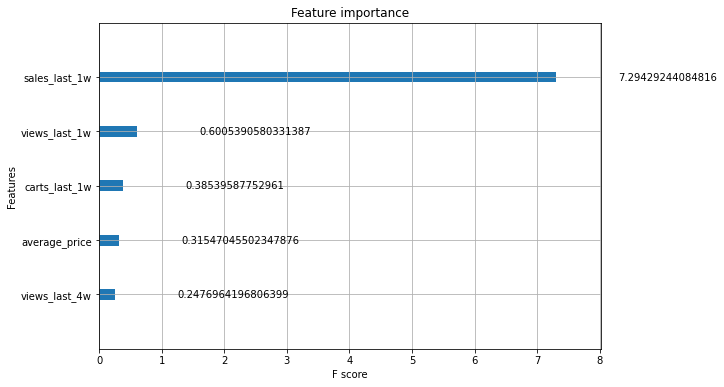

In [82]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=[9,6])
plot_importance(regr_trans.regressor_, max_num_features=5, importance_type ='gain', ax = ax)


In [83]:
feature_important = regr_trans.regressor_.get_booster().get_score(importance_type='weight')
feature_important = regr_trans.regressor_.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data

,score
sales_last_1w,7.294292
views_last_1w,0.600539
carts_last_1w,0.385396
average_price,0.315470
views_last_4w,0.247696
carts_last_2w,0.233590
carts_last_4w,0.227288
sales_last_2w,0.227148
views_last_2w,0.204654
sales_last_4w,0.146012


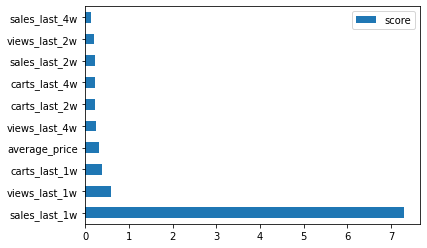

In [205]:
data.plot(kind='barh')

In [219]:
regr = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('regressor', SVR(kernel = 'rbf'))])
#                       ('regressor', RandomForestRegressor(max_depth=3, min_samples_split=3, n_estimators=700))])
                       ('regressor', RandomForestRegressor())])

regr_trans = TransformedTargetRegressor(regressor = regr,
                                        func = np.log,
                                        inverse_func = np.exp)

fitted = regr_trans.fit(X_train, y_train)
y_pred_trans = regr_trans.predict(X_test)

In [220]:
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))

OLS R2_score: 0.9519
MSE: 27037.2402
MAE: 85.0483


In [221]:
regr_trans

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num_log',
                                                                                       FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                           validate=True),
                                                                                       ['sales_last_1w',
                                                                                        'sales_last_2w',
                                                                                        'sales_last_4w',
                                                                                        'carts_last_1w',
                                                                                     

In [222]:
#regr_trans.regressor.named_steps['regressor'].coef_
regr_trans.regressor.named_steps
#classifier = regr_trans.best_estimator_.named_steps['regressor']

{'preprocessor': ColumnTransformer(transformers=[('num_log',
                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                      validate=True),
                                  ['sales_last_1w', 'sales_last_2w',
                                   'sales_last_4w', 'carts_last_1w',
                                   'carts_last_2w', 'carts_last_4w',
                                   'views_last_1w', 'views_last_2w',
                                   'views_last_4w', 'average_price']),
                                 ('num_lin',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                                  [])]),
 'regressor': RandomForestRegressor()}

In [223]:
regr_trans.regressor_.named_steps['regressor'].feature_importances_

array([0.70958723, 0.01672132, 0.00603283, 0.05360583, 0.0183105 ,
       0.01450076, 0.05735913, 0.00985004, 0.01019696, 0.10383541])

In [224]:
df_sales.columns

Index(['product_id', 'week_id', 'average_price', 'sales', 'sales_last_1w',
       'sales_last_2w', 'sales_last_4w', 'views_last_1w', 'views_last_2w',
       'views_last_4w', 'carts_last_1w', 'carts_last_2w', 'carts_last_4w'],
      dtype='object')

In [225]:
#res = y_test
#res = df_sales[df_sales['week_id'] == current_week][['product_id','product','brand','sales']]
res = df_sales[df_sales['week_id'] == current_week][['product_id','sales']]
res['sales_prediction'] = y_pred_trans.round(0).astype('int')
res = res.merge(product_summary,
                how = 'left',
                on = 'product_id')
res

,product_id,sales,sales_prediction,price_count,brand,category,product
0,1002524,1072.0,1007,59,apple,electronics,smartphone
1,1002525,151.0,134,7,apple,electronics,smartphone
2,1002528,221.0,220,21,apple,electronics,smartphone
3,1002532,266.0,203,20,apple,electronics,smartphone
4,1002540,145.0,162,24,apple,electronics,smartphone
...,...,...,...,...,...,...,...
157,1005174,920.0,758,5,samsung,electronics,smartphone
158,1307545,349.0,197,11,lenovo,computers,notebook
159,1005266,103.0,146,47,xiaomi,electronics,smartphone
160,4804718,471.0,633,27,apple,electronics,headphone


In [194]:
res.isna().sum()

product_id          0
sales               0
sales_prediction    0
price_count         0
brand               0
category            0
product             0
dtype: int64

In [212]:
r2_score = regr_trans.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_trans)
mae = mean_absolute_error(y_test, y_pred_trans)

score_str=(r'$R^2={:.3f}$' + '\n' + r'$MAE={:.3f}$').format(r2_score, mae)

In [213]:
ax_max = np.max([y_test.to_numpy().ravel().max(), y_pred_trans.max()])*2
ax_min = np.min([y_test.to_numpy().ravel().min(), y_pred_trans.min()])/2

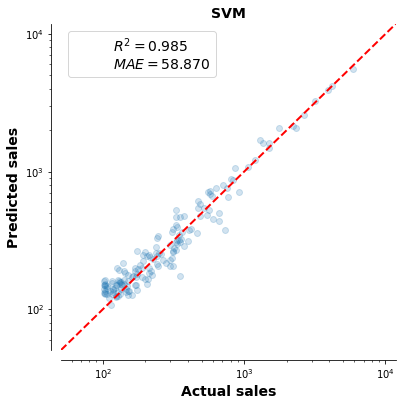

In [214]:
fig, ax = plt.subplots(figsize=[6,6])

ax.plot([ax_min, ax_max], [ax_min, ax_max], '--r', linewidth=2)
ax.scatter(y_test, y_pred_trans, alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([ax_min, ax_max])
ax.set_ylim([ax_min, ax_max])
ax.set_xlabel('Actual sales',fontsize=14,fontweight='bold')
ax.set_ylabel('Predicted sales',fontsize=14,fontweight='bold')
extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                      edgecolor='none', linewidth=0)
ax.legend([extra], [score_str], loc='upper left', prop={'size': 14})

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_title('SVM',fontsize=14,fontweight='bold')

plt.show()
#fig.savefig('output/sales_prediction_SVM.png', transparent=True, bbox_inches='tight', dpi=300)

In [198]:
X1.shape, y1.shape

((1479, 10), (1479, 1))

In [199]:
ds = df_sales.copy(deep = True)
ds[log_features] = np.log1p(ds[log_features])
X1 = ds[ds['week_id'] < current_week][numerical_features]
y1 = np.log1p(ds[ds['week_id'] < current_week][target])

X2 = ds[ds['week_id'] == current_week][numerical_features]
y2 = np.log1p(ds[ds['week_id'] == current_week][target])

#reg = LinearRegression()
reg = Lasso(alpha = 10e-3)
#reg = RandomForestRegressor()
reg.fit(X1, y1)
y_pd = reg.predict(X2)

print("R2_score: %.4f" %reg.score(X2, y2))
print("MSE: %.4f" %mean_squared_error(np.exp(y2), np.exp(y_pd)))
print("MAE: %.4f" %mean_absolute_error(np.exp(y2), np.exp(y_pd)))


R2_score: 0.2641
MSE: 451008.2800
MAE: 298.2878


In [231]:
dict_name = {'sales_last_1w': 'total purchases in last week',
             'sales_last_2w': 'total purchases in last 2 weeks',
             'sales_last_4w': 'total purchases in last 4 weeks',
             'carts_last_1w': 'total carts in last week',
             'carts_last_2w': 'total carts in last 2 weeks',
             'carts_last_4w': 'total carts in last 4 weeks',
             'views_last_1w': 'total views in last week',
             'views_last_2w': 'total views in last 2 weeks',
             'views_last_4w': 'total views in last 4 weeks',
             'average_price': 'product price',
#             'elasticity': 'price elasticity'
            }

df_feature_importance = pd.DataFrame(numerical_features, columns = ['feature'])
df_feature_importance['Lasso'] = reg.coef_.T
df_feature_importance['pipeline'] = regr_trans.regressor_.named_steps['regressor'].feature_importances_
df_feature_importance['abs'] = np.abs(df_feature_importance['pipeline'])
df_feature_importance['name'] = df_feature_importance['feature'].map(dict_name)
df_feature_importance.sort_values(by = 'abs', ascending = False, inplace = True)
df_feature_importance.set_index('name', inplace = True)
df_feature_importance

,feature,Lasso,pipeline,abs
name,,,,
total purchases in last week,sales_last_1w,0.085913,0.709587,0.709587
product price,average_price,-0.000000,0.103835,0.103835
total views in last week,views_last_1w,-0.078526,0.057359,0.057359
total carts in last week,carts_last_1w,0.120869,0.053606,0.053606
total carts in last 2 weeks,carts_last_2w,0.000000,0.018310,0.018310
total purchases in last 2 weeks,sales_last_2w,0.072138,0.016721,0.016721
total carts in last 4 weeks,carts_last_4w,0.000000,0.014501,0.014501
total views in last 4 weeks,views_last_4w,-0.003203,0.010197,0.010197
total views in last 2 weeks,views_last_2w,-0.040694,0.009850,0.009850


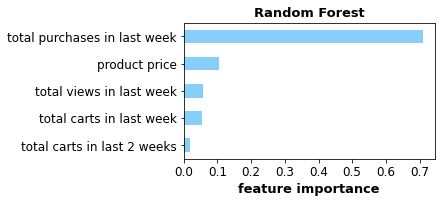

In [232]:
col = 'pipeline'
fig, ax = plt.subplots(figsize =[4.5, 2.5])
df_feature_importance[col].sort_values(ascending = False) \
                          .head(5).iloc[::-1] \
                          .plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
ax.set_ylabel('')
#ax.set_xlabel('feature importance', fontsize = 14)
ax.set_xlabel('feature importance', fontsize = 13, fontweight = 'bold')
ax.set_title('Random Forest', fontsize = 13, fontweight = 'bold')
fig.savefig('output/sales_feature_importance.png', transparent=True, bbox_inches='tight', dpi=300)

In [116]:
y_test.shape, y_pred_trans.shape

((162, 1), (162, 1))

In [159]:
import sklearn
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [168]:
get_feature_names(regr_trans.regressor_.named_steps['preprocessor'])

<ipython-input-159-914e3f59aa47>:33: UserWarning: Transformer num_log (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-159-914e3f59aa47>:33: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['num_log__sales_last_1w',
 'num_log__sales_last_2w',
 'num_log__sales_last_4w',
 'num_log__carts_last_1w',
 'num_log__carts_last_2w',
 'num_log__carts_last_4w',
 'num_log__views_last_1w',
 'num_log__views_last_2w',
 'num_log__views_last_4w',
 'num_log__average_price',
 'num_lin__elasticity']

In [165]:
preprocessor

ColumnTransformer(transformers=[('num_log',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['sales_last_1w', 'sales_last_2w',
                                  'sales_last_4w', 'carts_last_1w',
                                  'carts_last_2w', 'carts_last_4w',
                                  'views_last_1w', 'views_last_2w',
                                  'views_last_4w', 'average_price']),
                                ('num_lin',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['elasticity'])])

In [103]:
df_sales.corr()

,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w,carts_last_1w,carts_last_2w,carts_last_4w
week_id,1.000000,-0.028683,0.008122,0.114055,0.191291,0.269846,0.230000,0.342733,0.439463,0.204817,0.296843,0.343675
average_price,-0.028683,1.000000,-0.026081,-0.019455,-0.016292,-0.011209,-0.002464,-0.003620,-0.006285,-0.029462,-0.029618,-0.031473
sales,0.008122,-0.026081,1.000000,0.878057,0.830216,0.705095,0.762213,0.723335,0.612643,0.655896,0.671370,0.637504
sales_last_1w,0.114055,-0.019455,0.878057,1.000000,0.939621,0.784924,0.919998,0.865543,0.718514,0.884262,0.856585,0.774233
sales_last_2w,0.191291,-0.016292,0.830216,0.939621,1.000000,0.861452,0.852593,0.928918,0.799840,0.800989,0.919323,0.849851
sales_last_4w,0.269846,-0.011209,0.705095,0.784924,0.861452,1.000000,0.742528,0.823333,0.933913,0.715764,0.843037,0.961031
views_last_1w,0.230000,-0.002464,0.762213,0.919998,0.852593,0.742528,1.000000,0.911924,0.784124,0.917427,0.835291,0.767300
views_last_2w,0.342733,-0.003620,0.723335,0.865543,0.928918,0.823333,0.911924,1.000000,0.880912,0.813568,0.928731,0.860020
views_last_4w,0.439463,-0.006285,0.612643,0.718514,0.799840,0.933913,0.784124,0.880912,1.000000,0.712901,0.844112,0.942097
carts_last_1w,0.204817,-0.029462,0.655896,0.884262,0.800989,0.715764,0.917427,0.813568,0.712901,1.000000,0.861729,0.786381


In [139]:
df.columns

Index(['product_id', 'week_id', 'average_price', 'sales', 'sales_last_1w',
       'sales_last_2w', 'sales_last_4w', 'views_last_1w', 'views_last_2w',
       'views_last_4w', 'carts_last_1w', 'carts_last_2w', 'carts_last_4w'],
      dtype='object')

In [148]:
df_pd = df.groupby(['product_id']) \
          .agg(average_price = ('price' , 'mean'),
               sales = ('sales' , 'sum'),
               views = ('views' , 'sum'),
               carts = ('carts' , 'sum'),
              ) \
          .reset_index()
df_pd

,week_id,average_price,sales,views,carts
0,40,365.181505,98834,4614942,147861
1,41,349.686243,119109,5589150,124982
2,42,351.526547,144178,6289225,257290
3,43,347.812406,127010,5807432,217063
4,44,356.845515,108019,5642354,113682
5,45,364.576341,120252,7450219,212445
6,46,366.885938,252346,16377012,1210032
7,47,351.009242,123727,6795584,330446
8,48,346.069935,115288,5951014,310688


In [149]:
df_pd['r_sales'] = df_pd['sales']/df_pd['views']
df_pd['r_carts'] = df_pd['carts']/df_pd['views']
df_pd

,week_id,average_price,sales,views,carts,r_sales,r_carts
0,40,365.181505,98834,4614942,147861,0.021416,0.032040
1,41,349.686243,119109,5589150,124982,0.021311,0.022362
2,42,351.526547,144178,6289225,257290,0.022925,0.040910
3,43,347.812406,127010,5807432,217063,0.021870,0.037377
4,44,356.845515,108019,5642354,113682,0.019144,0.020148
5,45,364.576341,120252,7450219,212445,0.016141,0.028515
6,46,366.885938,252346,16377012,1210032,0.015409,0.073886
7,47,351.009242,123727,6795584,330446,0.018207,0.048627
8,48,346.069935,115288,5951014,310688,0.019373,0.052208


In [234]:
df_pd = df.groupby(['product_id']) \
          .agg(average_price = ('price' , 'mean'),
               sales = ('sales' , 'sum'),
               views = ('views' , 'sum'),
               carts = ('carts' , 'sum'),
              ) \
          .reset_index()
df_pd.head()

,product_id,average_price,sales,views,carts
0,1001588,127.959462,18,3979,16
1,1002062,108.276046,24,4791,46
2,1002098,380.142586,39,10234,91
3,1002099,380.183303,153,21728,0
4,1002100,378.356859,83,12359,165


In [236]:
df_pd = df_pd.merge(product_summary,
                    how = 'left',
                    on = 'product_id')

In [237]:
df_pd.head()

,product_id,average_price,sales,views,carts,price_count,brand,category,product
0,1001588,127.959462,18,3979,16,49,meizu,electronics,smartphone
1,1002062,108.276046,24,4791,46,7,samsung,electronics,smartphone
2,1002098,380.142586,39,10234,91,3,samsung,electronics,smartphone
3,1002099,380.183303,153,21728,0,2,samsung,electronics,smartphone
4,1002100,378.356859,83,12359,165,3,samsung,electronics,smartphone


In [265]:
marker_list = ['o','v','^','<','>','8','s','p','P','*','h','H','D','+','X']
marker_map = dict(zip(df_pd['category'].unique(), marker_list[:13]))
marker_map

{'electronics': 'o',
 'kids': 'v',
 'appliances': '^',
 'computers': '<',
 'sport': '>',
 'construction': '8',
 'stationery': 's',
 'furniture': 'p',
 'accessories': 'P',
 'auto': '*',
 'apparel': 'h',
 'medicine': 'H',
 'country_yard': 'D'}

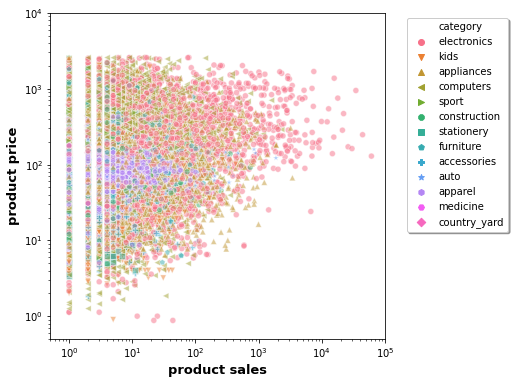

In [295]:
fig, ax = plt.subplots(figsize = [6,6])
sns.scatterplot(x = 'sales', 
                y = 'average_price',
                data = df_pd,
                alpha = 0.5,
                markers = marker_map,
                hue = 'category',
                style = 'category',
#                cmap = plt.cm.get_cmap('tab20'),
#                palette = 'tab20c',
#                palette = 'Spectral',
                ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('product sales', fontsize=13, fontweight='bold')
ax.set_ylabel('product price', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fancybox=True, shadow=True)
ax.set_xlim([0.5,1e5])
ax.set_ylim([0.5,1e4])
fig.savefig('output/product_sales_and_price.png', transparent=False, bbox_inches='tight', dpi=300)

In [301]:
product_summary['product'].unique()

array(['smartphone', 'carriage', 'tablet', 'headphone', 'unknown',
       'videoregister', 'clocks', 'subwoofer', 'tv', 'vacuum', 'desktop',
       'refrigerators', 'sewing_machine', 'oven', 'power_supply',
       'player', 'water_heater', 'blender', 'ebooks', 'monitor',
       'generator', 'telephone', 'mouse', 'keyboard', 'toilet', 'kettle',
       'saw', 'bicycle', 'bag', 'video', 'drill', 'steam_cooker',
       'coffee_machine', 'notebook', 'grill', 'hdd', 'massager',
       'printer', 'photo', 'camera', 'alarm', 'meat_grinder', 'chair',
       'skates', 'microwave', 'videocards', 'scales', 'hammok',
       'microphone', 'tonometer', 'motherboard', 'swing', 'faucet',
       'iron', 'light', 'toys', 'pillow', 'radar', 'hob', 'welding',
       'coffee_grinder', 'bath', 'hair_cutter', 'pump', 'air_heater',
       'hood', 'mixer', 'sofa', 'washer', 'dishwasher', 'dolls', 'bed',
       'air_conditioner', 'projector', 'cooler', 'toster', 'cpu',
       'diapers', 'memory', 'juicer', 'acou

In [302]:
product_summary['category'].unique()

array(['electronics', 'kids', 'unknown', 'auto', 'appliances',
       'computers', 'construction', 'furniture', 'sport', 'accessories',
       'country_yard', 'medicine', 'stationery', 'apparel'], dtype=object)

In [303]:
product_summary[product_summary['brand']=='artel']

,product_id,price_count,brand,category,product
183,1801766,66,artel,electronics,tv
210,1801762,60,artel,electronics,tv
230,1801806,57,artel,electronics,tv
258,1801805,54,artel,electronics,tv
713,3900775,45,artel,appliances,water_heater
...,...,...,...,...,...
198549,2601433,1,artel,unknown,unknown
198577,2601436,1,artel,unknown,unknown
198666,2601444,1,artel,unknown,unknown
198749,2601448,1,artel,unknown,unknown
